In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/wesad-main')

In [10]:
!pip install tensorflow
!pip install imblearn

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from scipy.special import softmax

In [11]:
!pip install autokeras
import autokeras as ak

print("AutoKeras version:", ak.__version__)

AutoKeras version: 2.0.0


In [12]:
from ae_feature_extractor import autoencoder
ae = autoencoder ()

## Chest and Wrist Physio modalities classification

In [ ]:
# Initialize lists to store results
scores_all = []
cms = []

# Loop through each subject for LOSO validation
for sid in ae.ids:
    print(f"Processing Subject {sid}...")

    # Load training and testing features
    feat = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso{sid}.pkl"))
    feat_test = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso{sid}.pkl"))

    # Separate features and labels
    y = feat[:, -1].astype(int)
    x = feat[:, :-1]
    y_test = feat_test[:, -1].astype(int)
    x_test = feat_test[:, :-1]

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    y_test = le.transform(y_test)

    # Apply SMOTE to balance the classes
    # smote = SMOTE(random_state=42)
    # x, y = smote.fit_resample(x, y)
    # print("Resampled training label distribution:", Counter(y))

    print("Training labels:", np.unique(y))
    print("Test labels:", np.unique(y_test))

    # Standardize features using the same scaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)  # Fit on training data
    x_test = scaler.transform(x_test)  # Transform test data using the same scaler

    # Verify scaling
    print("Training data range: min =", x.min(), ", max =", x.max())
    print("Test data range: min =", x_test.min(), ", max =", x_test.max())

    # Compute class weights (optional if imbalanced)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    # class_weights = dict(enumerate(class_weights))
    # print("Class weights:", class_weights)

    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")

    # Define AutoKeras AutoModel
    clf = ak.AutoModel(
        inputs=ak.Input(shape=(x.shape[1],)),  # Explicit input shape
        outputs=ak.ClassificationHead(num_classes=num_classes),
        max_trials=30,  # Increase trials for better architectures - 30
        overwrite=True,
        seed=42
    )

    # Define EarlyStopping callback
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    # Train the AutoKeras model
    clf.fit(
        x=x,
        y=y,
        epochs=50,  # Increase epochs for longer training - 50
        validation_split=0.2,
        verbose=1,
        #class_weight=class_weights,
        callbacks=[early_stop]
    )

    # Predict on the test set
    y_pred_probs = clf.predict(x_test)
    print("Raw probabilities (first 10):", y_pred_probs[:10])

    # Step 1: Convert to numeric if necessary
    try:
        y_pred_probs = y_pred_probs.astype(float)
    except ValueError:
        print("y_pred_probs contains non-numeric values. Fix the model output.")

    # Step 2: Check if probabilities sum to 1
    if not np.allclose(y_pred_probs.sum(axis=-1), 1.0):
        print("Probabilities do not sum to 1. Applying softmax.")
        y_pred_probs = softmax(y_pred_probs, axis=-1)

    # Step 3: Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=-1)
    print("Predicted labels (first 10):", y_pred[:10])

    # Decode predictions back to original labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Evaluate predictions
    acc = accuracy_score(y_test, y_pred_decoded)
    precision = precision_score(y_test, y_pred_decoded, average="weighted")
    recall = recall_score(y_test, y_pred_decoded, average="weighted")
    f1 = f1_score(y_test, y_pred_decoded, average="weighted")
    cm = confusion_matrix(y_test, y_pred_decoded)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Store results
    scores_all.append([sid, acc, precision, recall, f1])
    cms.append(cm)

# Print summary of results
print("Summary of Results:")
for result in scores_all:
    print(f"Subject {result[0]}: Accuracy = {result[1]:.4f}, F1 Score = {result[2]:.4f}")

Trial 30 Complete [00h 00m 31s]
val_loss: 0.46446603536605835

Best val_loss So Far: 0.4198595881462097
Total elapsed time: 00h 25m 36s
Epoch 1/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9093 - loss: 0.3252
Epoch 2/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9113 - loss: 0.3801
Epoch 3/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9322 - loss: 0.2982
Epoch 4/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9434 - loss: 0.2532
Epoch 5/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9450 - loss: 0.2170
Epoch 6/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9434 - loss: 0.2089
Epoch 7/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9455 - loss: 0.2003
Epoch 8/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9500 - loss: 0.1921
Epoch 9/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9535 - loss: 0.1833
Epoch 10/50
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9539 - loss: 0.1711
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 124))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Raw probabilities (first 10): [['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']]
Probabilities do not sum to 1. Applying softmax.
Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Subject 17 - Accuracy: 0.3177, F1 Score: 0.1532
Summary of Results:
Subject 2: Accuracy = 0.2900, F1 Score = 0.0841
Subject 3: Accuracy = 0.2971, F1 Score = 0.0883
Subject 4: Accuracy = 0.2933, F1 Score = 0.0860
Subject 5: Accuracy = 0.2909, F1 Score = 0.0846
Subject 6: Accuracy = 0.2952, F1 Score = 0.0871
Subject 7: Accuracy = 0.2912, F1 Score = 0.0848
Subject 8: Accuracy = 0.3030, F1 Score = 0.0918
Subject 9: Accuracy = 0.2936, F1 Score = 0.0862
Subject 10: Accuracy = 0.3184, F1 Score = 0.1014
Subject 11: Accuracy = 0.3053, F1 Score = 0.0932
Subject 13: Accuracy = 0.2983, F1 Score = 0.0890
Subject 14: Accuracy = 0.3031, F1 Score = 0.0919
Subject 15: Accuracy = 0.3072, F1 Score = 0.0944
Subject 16: Accuracy = 0.3030, F1 Score = 0.0918
Subject 17: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
np.array(scores_all)[:,1].mean() #accuracy

np.float64(0.30048480843088676)

In [ ]:
np.array(scores_all)[:,1].std()

np.float64(0.008704756157532285)

In [ ]:
np.array(scores_all)[:,2].mean() #precision

np.float64(0.09036689287750882)

In [ ]:
np.array(scores_all)[:,2].std()

np.float64(0.005289663356402085)

In [ ]:
np.array(scores_all)[:,3].mean() #recall

np.float64(0.30048480843088676)

In [ ]:
np.array(scores_all)[:,3].std()

np.float64(0.008704756157532285)

In [ ]:
np.array(scores_all)[:,4].mean() #f1-score

np.float64(0.13892618897093287)

In [ ]:
np.array(scores_all)[:,4].std()

np.float64(0.007167402331605027)

### Confusion Matrices per subject and for all subjects combined

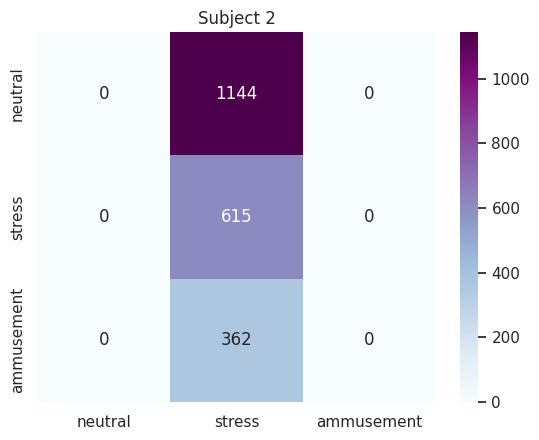

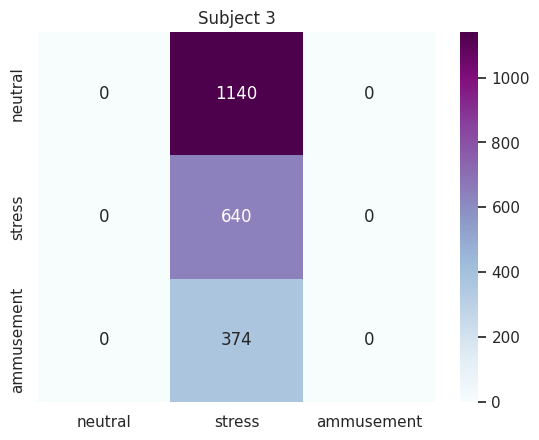

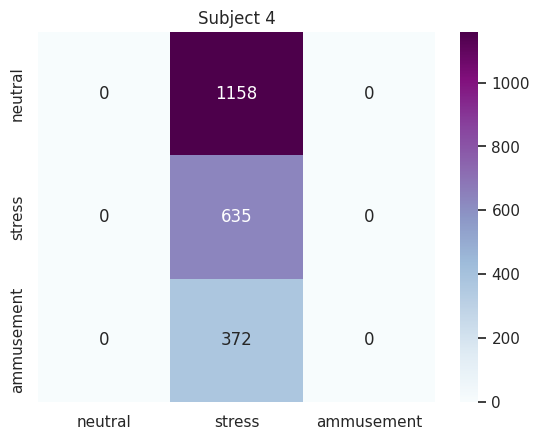

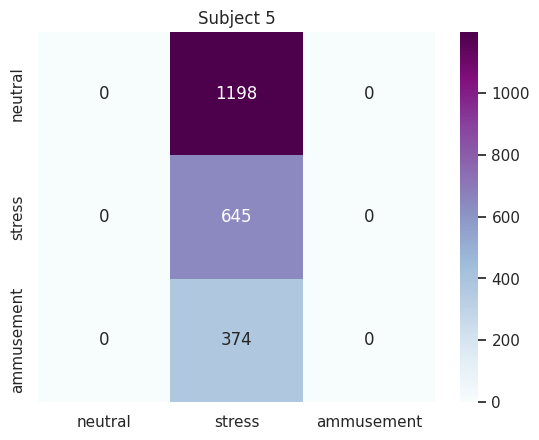

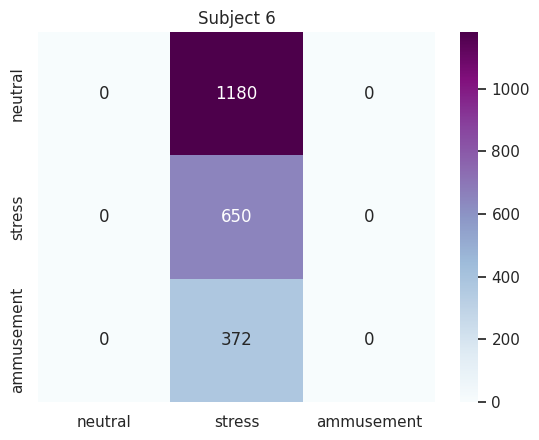

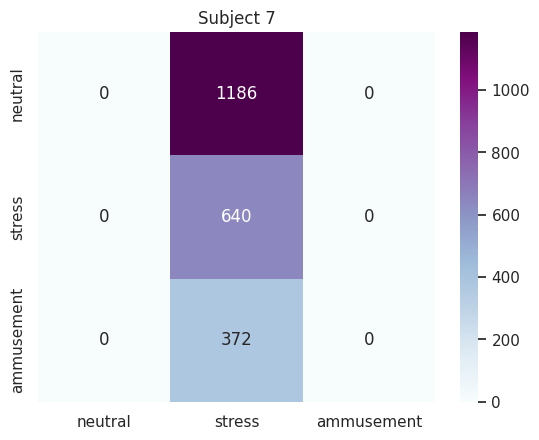

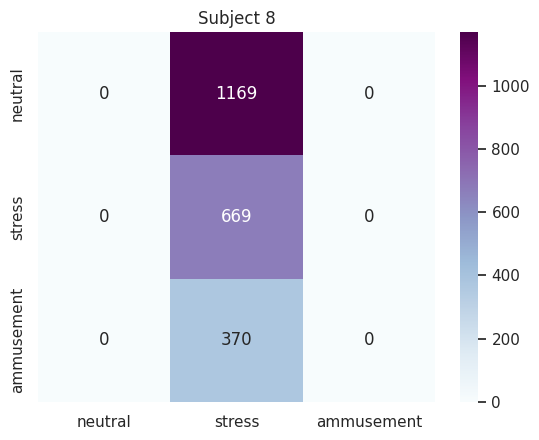

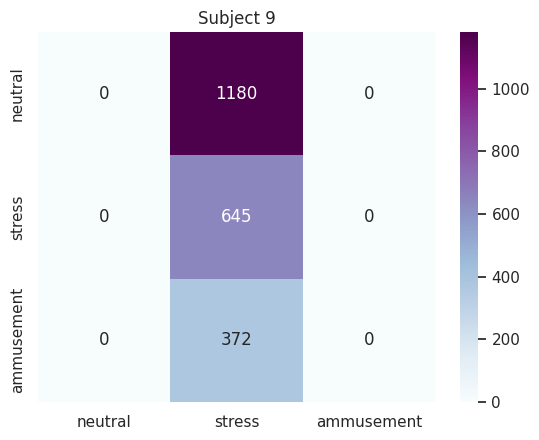

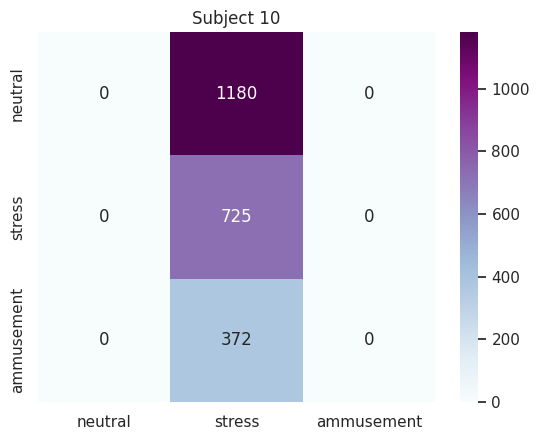

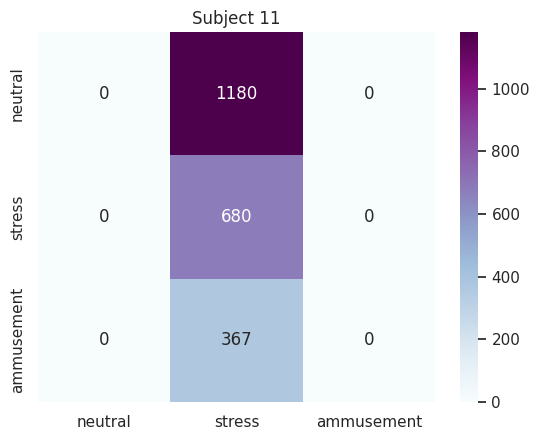

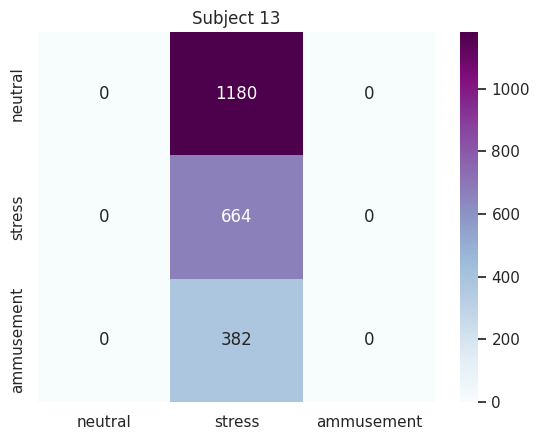

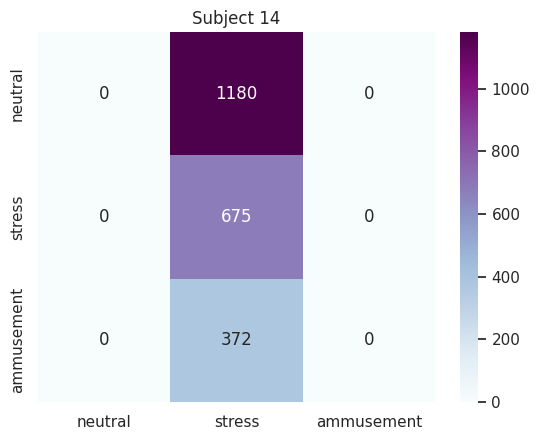

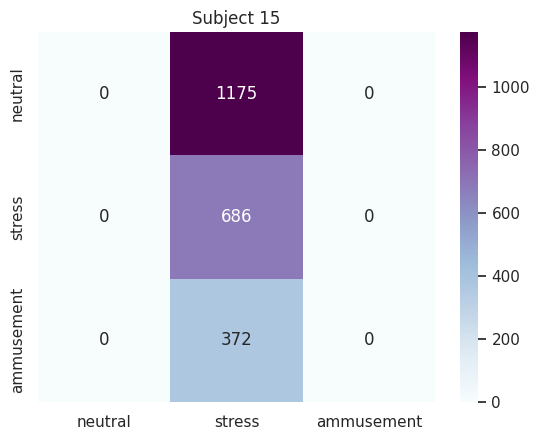

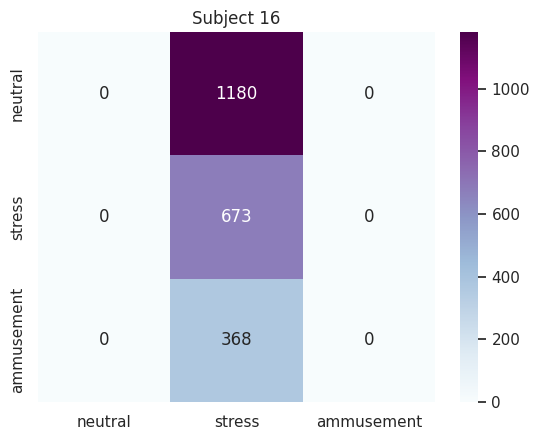

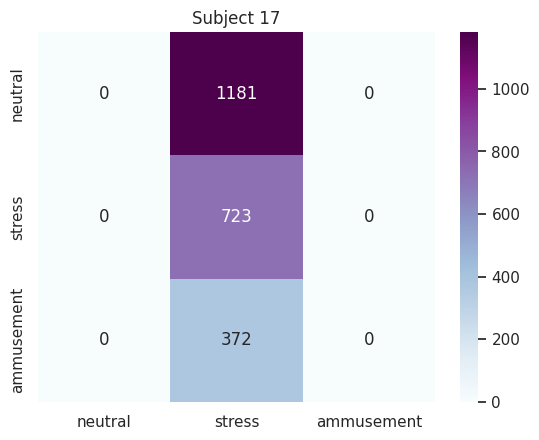

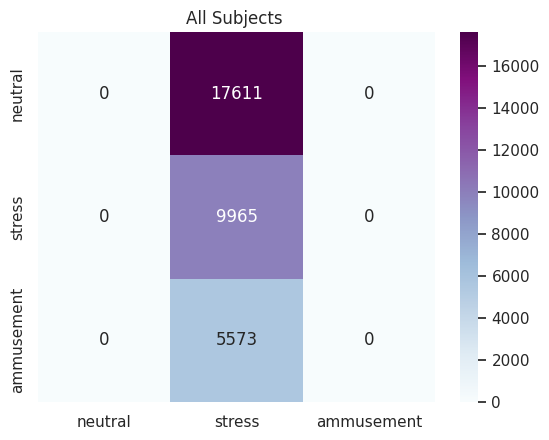

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_all)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()


## Chest only physio modalities classification

In [13]:
# Initialize lists to store results
scores_c = []
cms = []

# Loop through each subject for LOSO validation
for sid in ae.ids:
    print(f"Processing Subject {sid}...")

    # Load training and testing features
    feat = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso{sid}.pkl"))
    feat_test = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso{sid}.pkl"))

    # Separate features and labels
    y = feat[:, -1].astype(int)
    x = feat[:,:80]
    y_test = feat_test[:, -1].astype(int)
    x_test = feat_test[:,:80]

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    y_test = le.transform(y_test)

    # Apply SMOTE to balance the classes
    # smote = SMOTE(random_state=42)
    # x, y = smote.fit_resample(x, y)
    # print("Resampled training label distribution:", Counter(y))

    print("Training labels:", np.unique(y))
    print("Test labels:", np.unique(y_test))

    # Standardize features using the same scaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)  # Fit on training data
    x_test = scaler.transform(x_test)  # Transform test data using the same scaler

    # Verify scaling
    print("Training data range: min =", x.min(), ", max =", x.max())
    print("Test data range: min =", x_test.min(), ", max =", x_test.max())

    # Compute class weights (optional if imbalanced)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    # class_weights = dict(enumerate(class_weights))
    # print("Class weights:", class_weights)

    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")

    # Define AutoKeras AutoModel
    clf = ak.AutoModel(
        inputs=ak.Input(shape=(x.shape[1],)),  # Explicit input shape
        outputs=ak.ClassificationHead(num_classes=num_classes),
        max_trials=15,  # Increase trials for better architectures - 15
        overwrite=True,
        seed=42
    )

    # Define EarlyStopping callback
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train the AutoKeras model
    clf.fit(
        x=x,
        y=y,
        epochs=25,  # Increase epochs for longer training - 25
        validation_split=0.2,
        verbose=1,
        # class_weight=class_weights,
        callbacks=[early_stop]
    )

    # Predict on the test set
    y_pred_probs = clf.predict(x_test)
    print("Raw probabilities (first 10):", y_pred_probs[:10])
    y_pred = np.argmax(y_pred_probs, axis=-1)  # Convert probabilities to class labels
    print("Predicted labels (first 10):", y_pred[:10])

    # Decode predictions back to original labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Evaluate predictions
    acc = accuracy_score(y_test, y_pred_decoded)
    precision = precision_score(y_test, y_pred_decoded, average="weighted")
    recall = recall_score(y_test, y_pred_decoded, average="weighted")
    f1 = f1_score(y_test, y_pred_decoded, average="weighted")
    cm = confusion_matrix(y_test, y_pred_decoded)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Store results
    scores_c.append([sid, acc, precision, recall, f1])
    cms.append(cm)

# Print summary of results
print("Summary of Results:")
for result in scores_c:
    print(f"Subject {result[0]}: Accuracy = {result[1]:.4f}, F1 Score = {result[2]:.4f}")

Trial 15 Complete [00h 00m 27s]
val_loss: 0.4105604588985443

Best val_loss So Far: 0.38032737374305725
Total elapsed time: 00h 08m 12s
Epoch 1/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6326 - loss: 0.9466
Epoch 2/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6987 - loss: 0.8074
Epoch 3/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7259 - loss: 0.7357
Epoch 4/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7430 - loss: 0.7019
Epoch 5/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7611 - loss: 0.6627
Epoch 6/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7740 - loss: 0.6560
Epoch 7/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7738 - loss: 0.6155
Epoch 8/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7816 - loss: 0.5959
Epoch 9/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7878 - loss: 0.5902
Epoch 10/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7865 - loss: 0.5928
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 80))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Raw probabilities (first 10): [['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']
 ['0']]
Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Subject 17 - Accuracy: 0.3177, F1 Score: 0.1532
Summary of Results:
Subject 2: Accuracy = 0.2900, F1 Score = 0.0841
Subject 3: Accuracy = 0.2971, F1 Score = 0.0883
Subject 4: Accuracy = 0.2933, F1 Score = 0.0860
Subject 5: Accuracy = 0.2909, F1 Score = 0.0846
Subject 6: Accuracy = 0.2952, F1 Score = 0.0871
Subject 7: Accuracy = 0.2912, F1 Score = 0.0848
Subject 8: Accuracy = 0.3030, F1 Score = 0.0918
Subject 9: Accuracy = 0.2936, F1 Score = 0.0862
Subject 10: Accuracy = 0.3184, F1 Score = 0.1014
Subject 11: Accuracy = 0.3053, F1 Score = 0.0932
Subject 13: Accuracy = 0.2983, F1 Score = 0.0890
Subject 14: Accuracy = 0.3031, F1 Score = 0.0919
Subject 15: Accuracy = 0.3072, F1 Score = 0.0944
Subject 16: Accuracy = 0.3030, F1 Score = 0.0918
Subject 17: Accuracy = 0.3177, F1 Score = 0.1009


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
np.array(scores_c)[:,1].mean() #accuracy

np.float64(0.30048480843088676)

In [15]:
np.array(scores_c)[:,1].std()

np.float64(0.008704756157532285)

In [16]:
np.array(scores_c)[:,2].mean() #precision

np.float64(0.09036689287750882)

In [17]:
np.array(scores_c)[:,2].std()

np.float64(0.005289663356402085)

In [18]:
np.array(scores_c)[:,3].mean() #recall

np.float64(0.30048480843088676)

In [19]:
np.array(scores_c)[:,3].std()

np.float64(0.008704756157532285)

In [20]:
np.array(scores_c)[:,4].mean() #f1-score

np.float64(0.13892618897093287)

In [21]:
np.array(scores_c)[:,4].std()

np.float64(0.007167402331605027)

### Confusion Matrices per subject and for all subjects combined

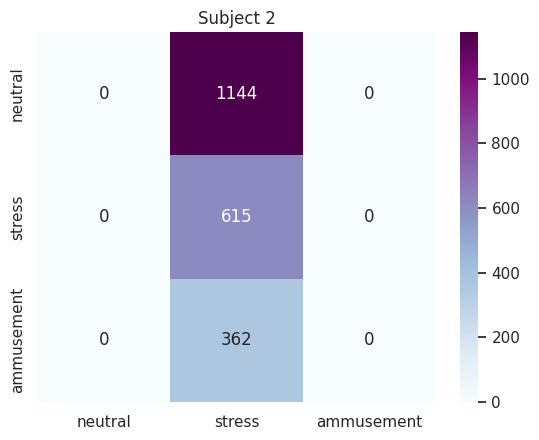

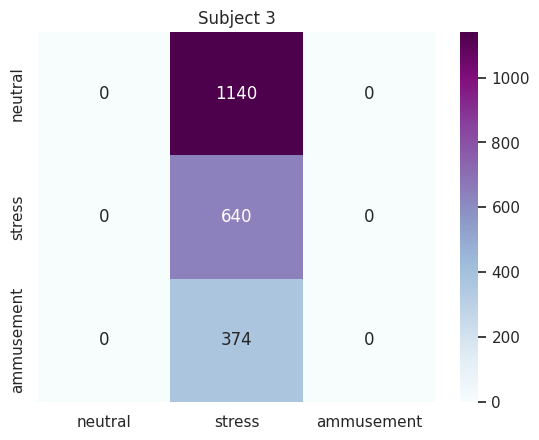

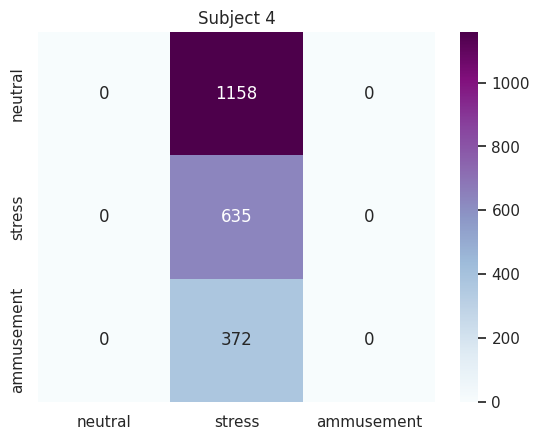

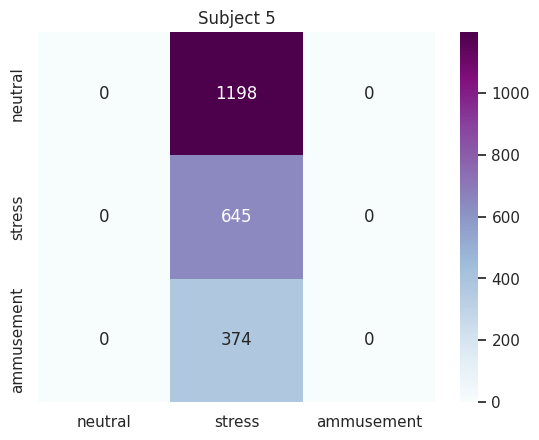

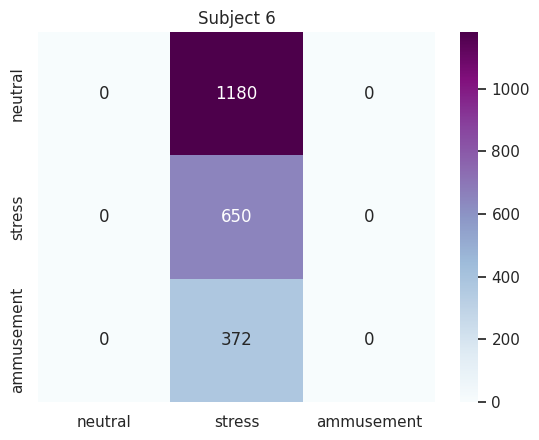

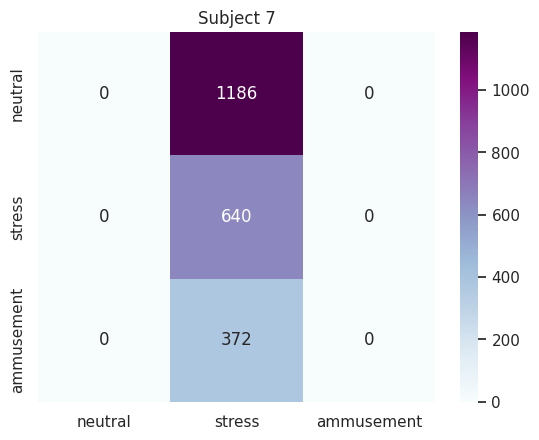

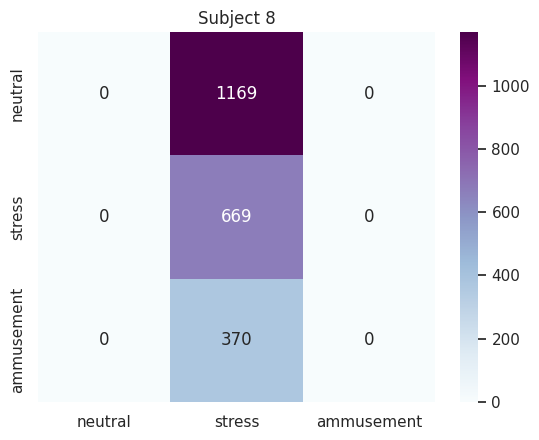

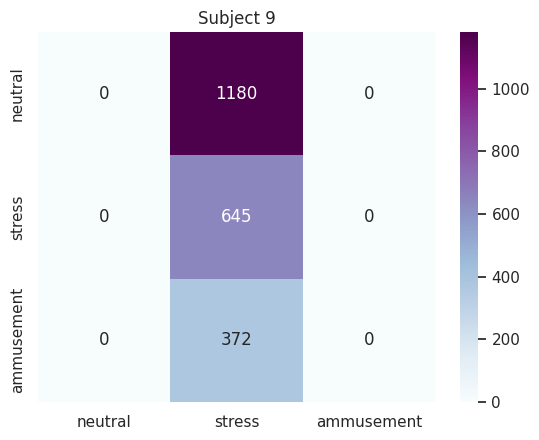

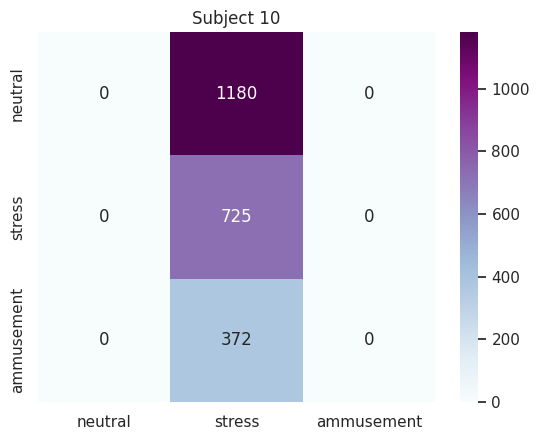

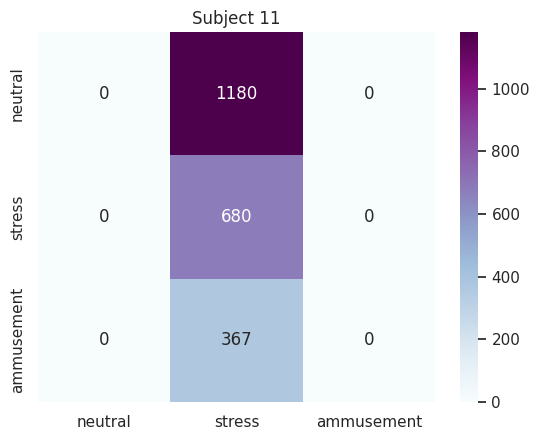

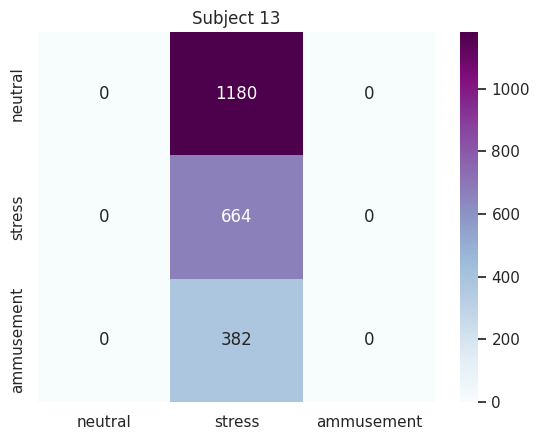

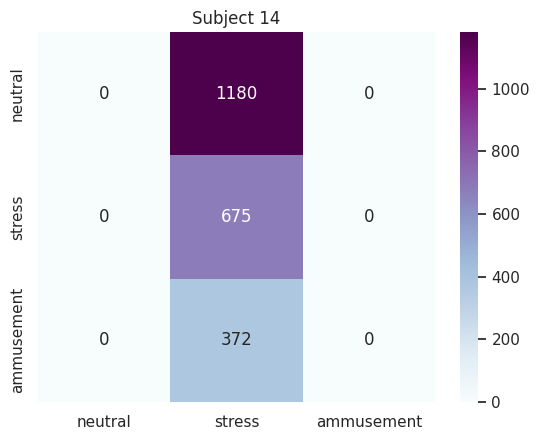

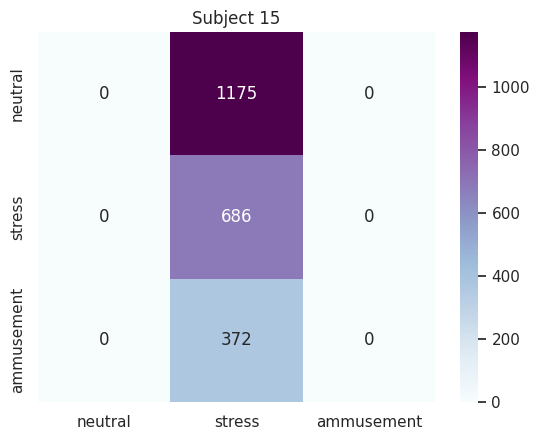

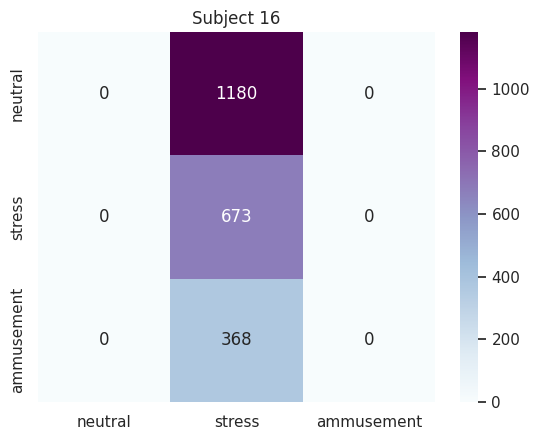

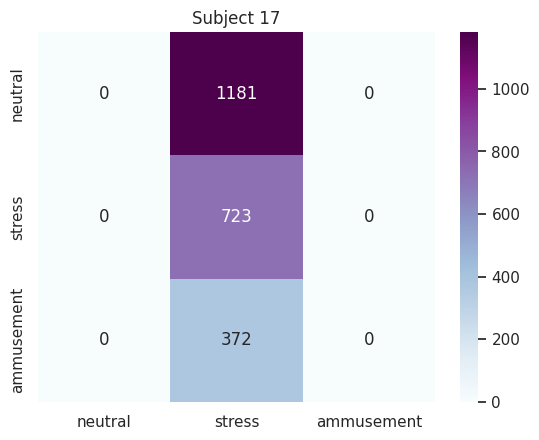

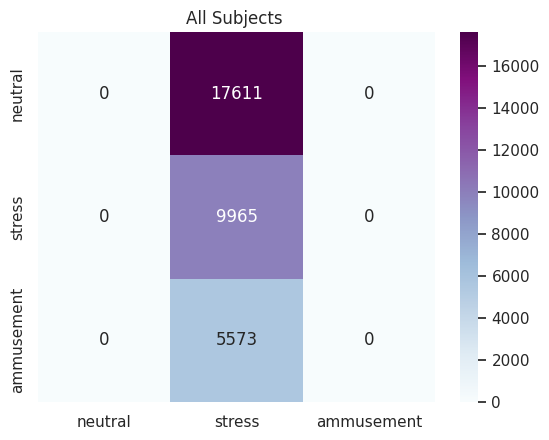

In [22]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_c)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()

## Wrist only physio modalities classification

In [23]:
# Initialize lists to store results
scores_w = []
cms = []

# Loop through each subject for LOSO validation
for sid in ae.ids:
    # Load training and testing features
    feat = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/train/feat_loso{sid}.pkl"))
    feat_test = np.array(pd.read_pickle(f"/content/drive/MyDrive/Colab Notebooks/wesad-main/features/test/feat_loso{sid}.pkl"))

    # Extract wrist-only features
    y = feat[:, -1]
    x = feat[:, 80:-1]
    y_test = feat_test[:, -1]
    x_test = feat_test[:, 80:-1]

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    y_test = le.transform(y_test)

    # Apply SMOTE to balance the classes
    # smote = SMOTE(random_state=42)
    # x, y = smote.fit_resample(x, y)
    # print("Resampled training label distribution:", Counter(y))

    print("Training labels:", np.unique(y))
    print("Test labels:", np.unique(y_test))

    # Standardize features using the same scaler
    scaler = StandardScaler()
    x = scaler.fit_transform(x)  # Fit on training data
    x_test = scaler.transform(x_test)  # Transform test data using the same scaler

    # Verify scaling
    print("Training data range: min =", x.min(), ", max =", x.max())
    print("Test data range: min =", x_test.min(), ", max =", x_test.max())

    # Compute class weights (optional if imbalanced)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    # class_weights = dict(enumerate(class_weights))
    # print("Class weights:", class_weights)

    num_classes = len(np.unique(y))
    print(f"Number of classes: {num_classes}")

    # Define AutoKeras AutoModel
    clf = ak.AutoModel(
        inputs=ak.Input(shape=(x.shape[1],)),  # Explicit input shape
        outputs=ak.ClassificationHead(num_classes=num_classes),
        max_trials=15,  # Increase trials for better architectures - 15
        overwrite=True,
        seed=42
    )

    # Define EarlyStopping callback
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train the AutoKeras model
    clf.fit(
        x=x,
        y=y,
        epochs=25,  # Increase epochs for longer training - 25
        validation_split=0.2,
        verbose=1,
        # class_weight=class_weights,
        callbacks=[early_stop]
    )

    # Predict on the test set
    y_pred_probs = clf.predict(x_test)
    print("Raw probabilities (first 10):", y_pred_probs[:10])
    y_pred = np.argmax(y_pred_probs, axis=-1)  # Convert probabilities to class labels
    print("Predicted labels (first 10):", y_pred[:10])

    # Decode predictions back to original labels
    y_pred_decoded = le.inverse_transform(y_pred)

    # Evaluate predictions
    acc = accuracy_score(y_test, y_pred_decoded)
    precision = precision_score(y_test, y_pred_decoded, average="weighted")
    recall = recall_score(y_test, y_pred_decoded, average="weighted")
    f1 = f1_score(y_test, y_pred_decoded, average="weighted")
    cm = confusion_matrix(y_test, y_pred_decoded)

    # Print results for this subject
    print(f"Subject {sid} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

    # Store results
    scores_w.append([sid, acc, precision, recall, f1])
    cms.append(cm)

# Print summary of results
print("Summary of Results:")
for result in scores_w:
    print(f"Subject {result[0]}: Accuracy = {result[1]:.4f}, F1 Score = {result[2]:.4f}")

Trial 15 Complete [00h 00m 25s]
val_loss: 0.8158079385757446

Best val_loss So Far: 0.779172420501709
Total elapsed time: 00h 08m 49s
Epoch 1/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6138 - loss: 0.9514
Epoch 2/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7340 - loss: 0.7377
Epoch 3/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7420 - loss: 0.7133
Epoch 4/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7462 - loss: 0.6965
Epoch 5/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7466 - loss: 0.6849
Epoch 6/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7482 - loss: 0.6690
Epoch 7/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7492 - loss: 0.6633
Epoch 8/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7466 - loss: 0.6495
Epoch 9/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7473 - loss: 0.6434
Epoch 10/25
965/965 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7521 - loss: 0.6310
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 44))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Raw probabilities (first 10): [['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']
 ['1']]
Predicted labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Subject 17 - Accuracy: 0.3177, F1 Score: 0.1532
Summary of Results:
Subject 2: Accuracy = 0.2900, F1 Score = 0.0841
Subject 3: Accuracy = 0.2971, F1 Score = 0.0883
Subject 4: Accuracy = 0.2933, F1 Score = 0.0860
Subject 5: Accuracy = 0.2909, F1 Score = 0.0846
Subject 6: Accuracy = 0.2952, F1 Score = 0.0871
Subject 7: Accuracy = 0.2912, F1 Score = 0.0848
Subject 8: Accuracy = 0.3030, F1 Score = 0.0918
Subject 9: Accuracy = 0.2936, F1 Score = 0.0862
Subject 10: Accuracy = 0.3184, F1 Score = 0.1014
Subject 11: Accuracy = 0.3053, F1 Score = 0.0932
Subject 13: Accuracy = 0.2983, F1 Score = 0.0890
Subject 14: Accuracy = 0.3031, F1 Score = 0.0919
Subject 15: Accuracy = 0.3072, F1 Score = 0.0944
Subject 16: Accuracy = 0.3030, F1 Score = 0.0918
Subject 17: Accuracy = 0.3177, F1 Score = 0.1009


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
np.array(scores_w)[:,1].mean() #accuracy

np.float64(0.30048480843088676)

In [25]:
np.array(scores_w)[:,1].std()

np.float64(0.008704756157532285)

In [26]:
np.array(scores_w)[:,2].mean() #precision

np.float64(0.09036689287750882)

In [27]:
np.array(scores_w)[:,2].std()

np.float64(0.005289663356402085)

In [28]:
np.array(scores_w)[:,3].mean() #recall

np.float64(0.30048480843088676)

In [29]:
np.array(scores_w)[:,3].std()

np.float64(0.008704756157532285)

In [30]:
np.array(scores_w)[:,4].mean() #f1-score

np.float64(0.13892618897093287)

In [31]:
np.array(scores_w)[:,4].std()

np.float64(0.007167402331605027)

### Confusion Matrices per subject and for all subjects combined

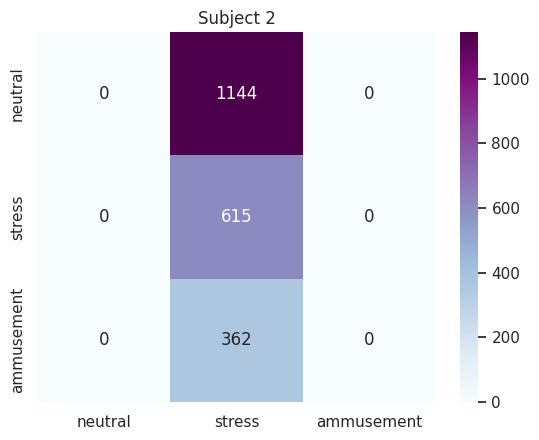

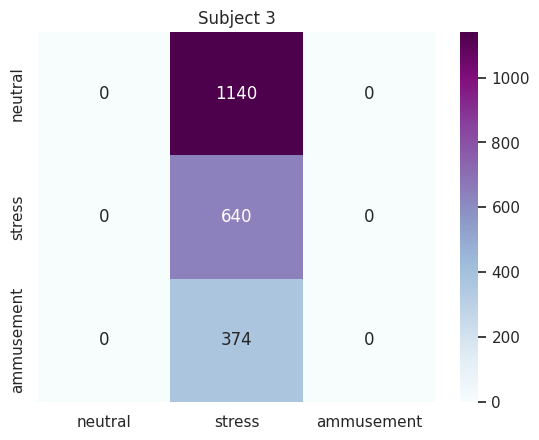

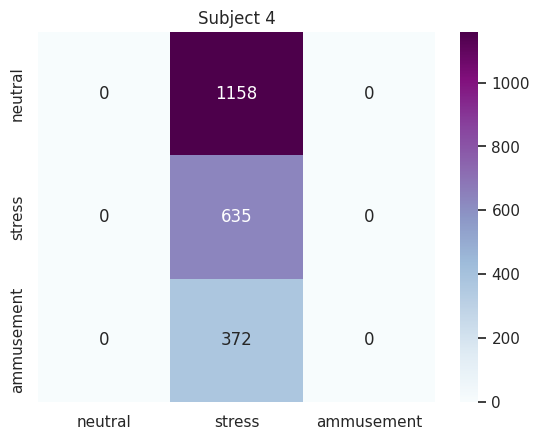

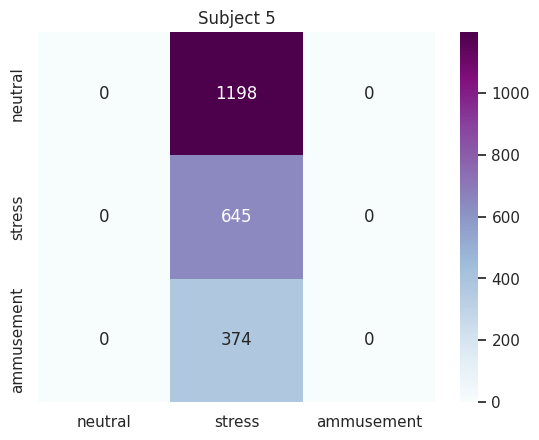

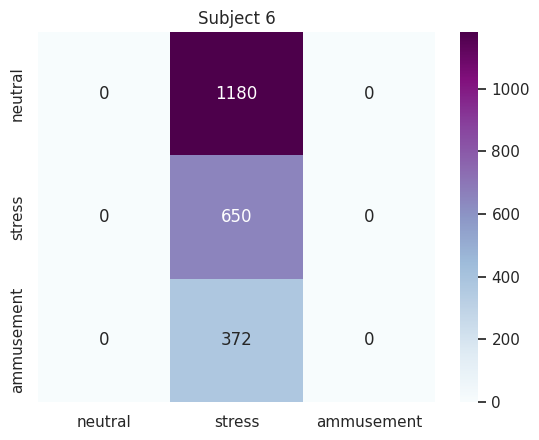

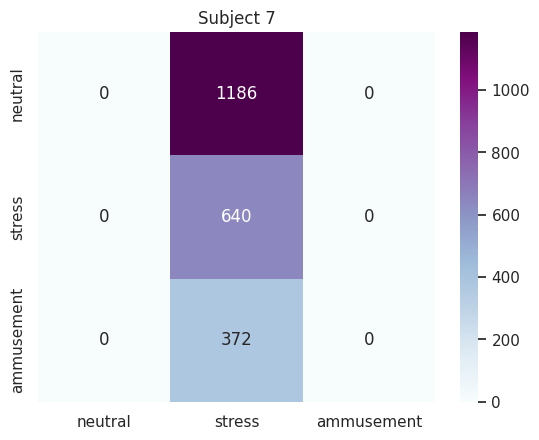

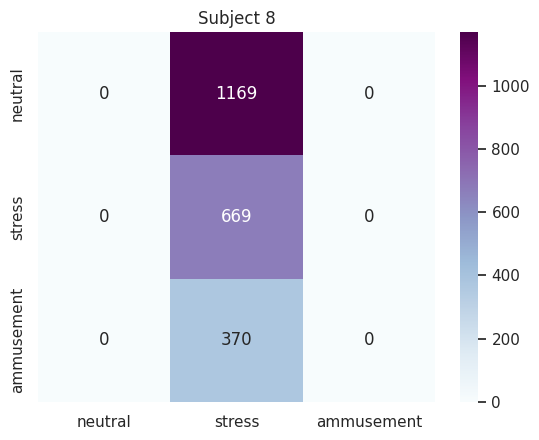

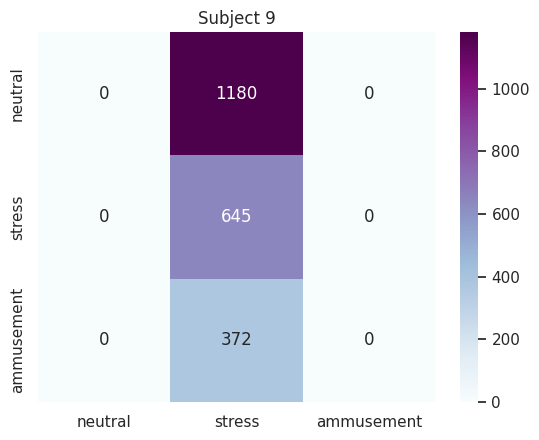

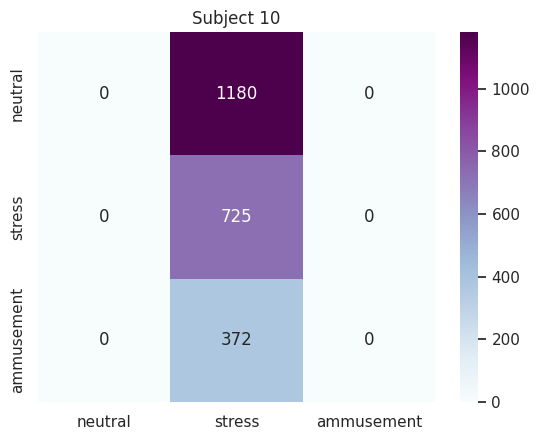

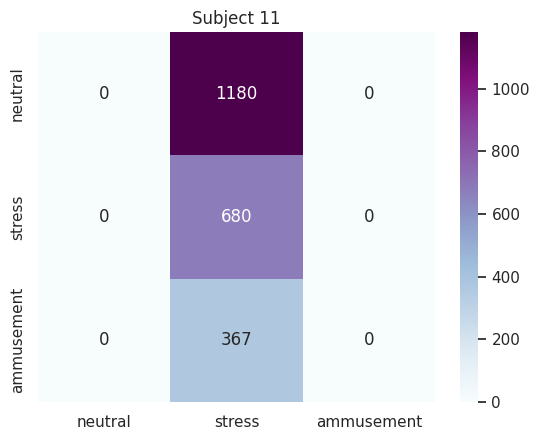

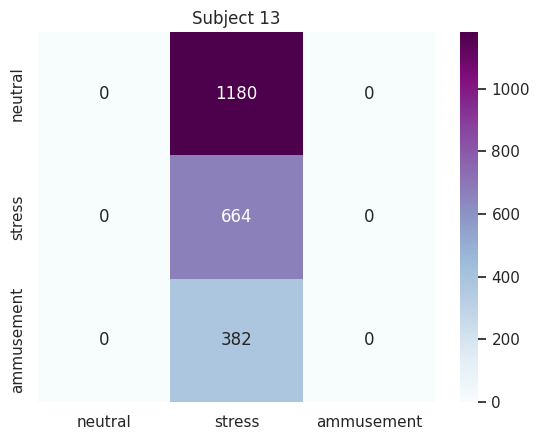

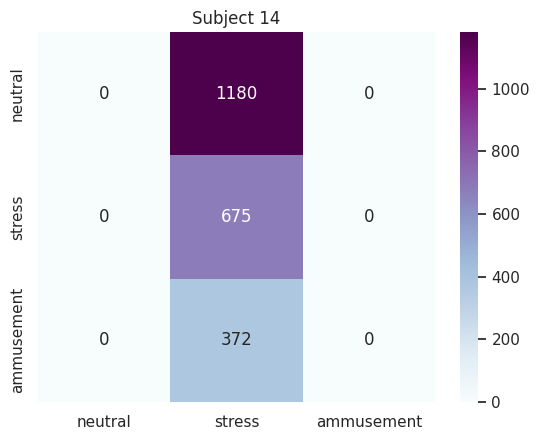

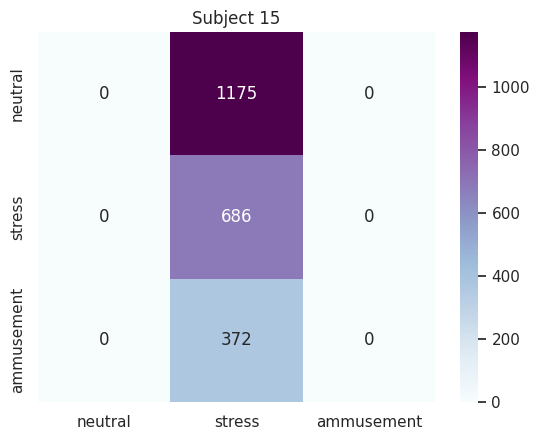

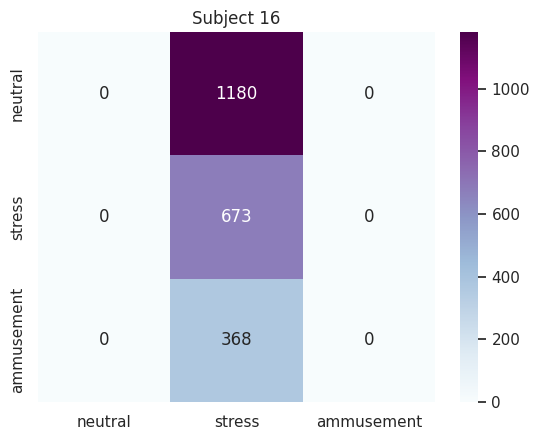

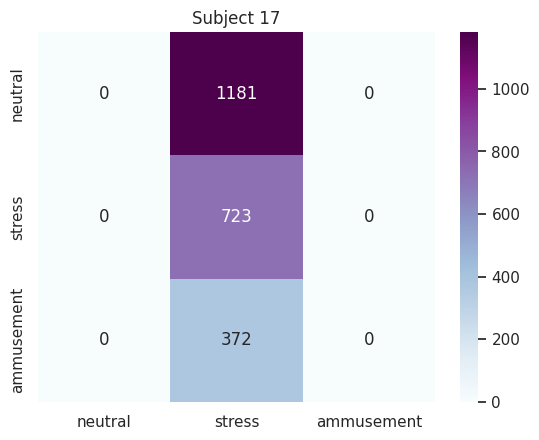

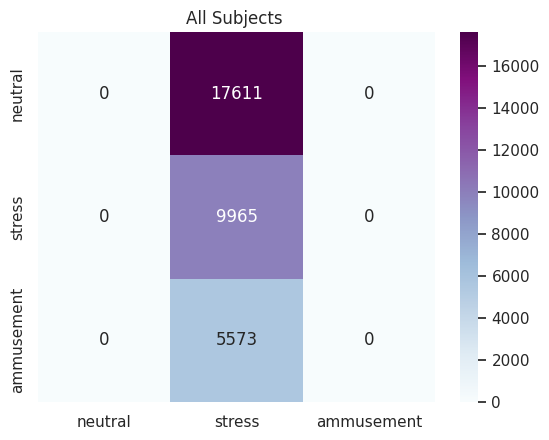

In [32]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
cm_all = np.zeros((3,3))
class_names = ['neutral', 'stress', 'ammusement']
for sid, cm in list(zip(np.array(scores_w)[:,0], cms)):
    #print("Subject ", int(sid))
    cm_all += cm
    df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
    sn.set(font_scale=1) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
    plt.title("Subject " + str(int(sid)))
    plt.show()

df_cm = pd.DataFrame(cm_all.astype(int), columns=class_names, index=class_names)
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="BuPu",  fmt='d') # font size
plt.title("All Subjects ")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

X = np.arange(15)
fig = plt.figure(figsize=(14, 6))
ax = fig.add_axes([0,0,1,1])
width = 0.25
ind = np.array(scores_all)[:,0].astype(int)
ax.set_xticks(ind)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('F1-Score', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=16)
ax.set_title("F1-Scores by Subjects and Modalities", fontsize=20)
ax.bar(ind+0.00, np.array(scores_all)[:,2]*100, color = 'b', width = 0.25)
ax.bar(ind+0.25, np.array(scores_c)[:,2]*100, color = 'g', width = 0.25)
ax.bar(ind+0.50, np.array(scores_w)[:,2]*100, color = 'r', width = 0.25)
ax.legend(labels=['Both', 'Chest', 'Wrist'])